# Encontre o coração

Disciplina: Processamento Digital de Sinais

Aluno: Gabriel Finger Conte

## Importando bibliotecas e demais dados

In [1]:
# Importando bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

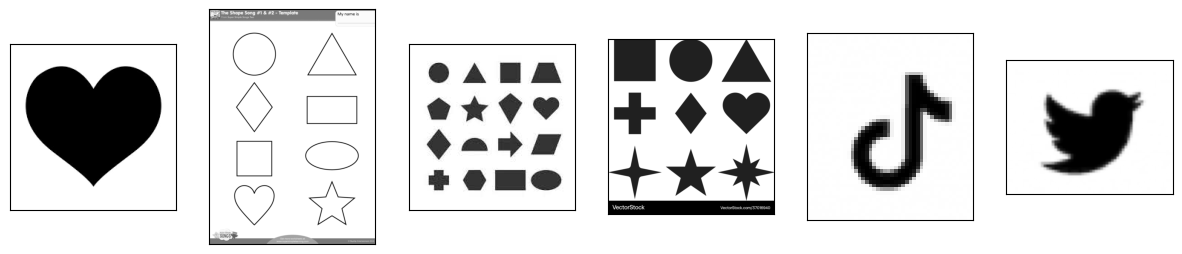

In [2]:
# Importamos as imagens em escala de cinza, pois a coloração não irá impactar na análise de contornos

# Importa a imagem com o modelo de coração a ser considerado no algoritmo
baseHeart = cv2.imread("shapes/heart.png",cv2.IMREAD_GRAYSCALE)

# Importa as demais imagens de teste
imgs = []
for imgPath in glob.glob(".\\shapes\\*"):
    if(imgPath != ".\\shapes\\heart.png"):
        imgs.append(cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE))

# Verifica o resultado da importação
plt.figure(figsize=(15,5))
plt.subplot(1,6,1)
plt.imshow(baseHeart,cmap="gray");plt.xticks([]);plt.yticks([])
for i in range(0,5):
    plt.subplot(1,6,i+2)
    plt.imshow(imgs[i],cmap="gray");plt.xticks([]);plt.yticks([])
plt.show()

In [113]:
# Definindo funções auxiliares

# Binariza uma imagem
def binarize(img, inv=True):
    if inv:
        val, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else: 
        val, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return val, th

# Retorna os contornos de uma imagem
def get_contours(img):
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy

# Transforma um contorno em um sinal complexo
def transform_contour(contour):
    complex_contour = contour[:,0,0] + contour[:,0,1]*1j
    return complex_contour

## Analisando o formato base (heart.png)

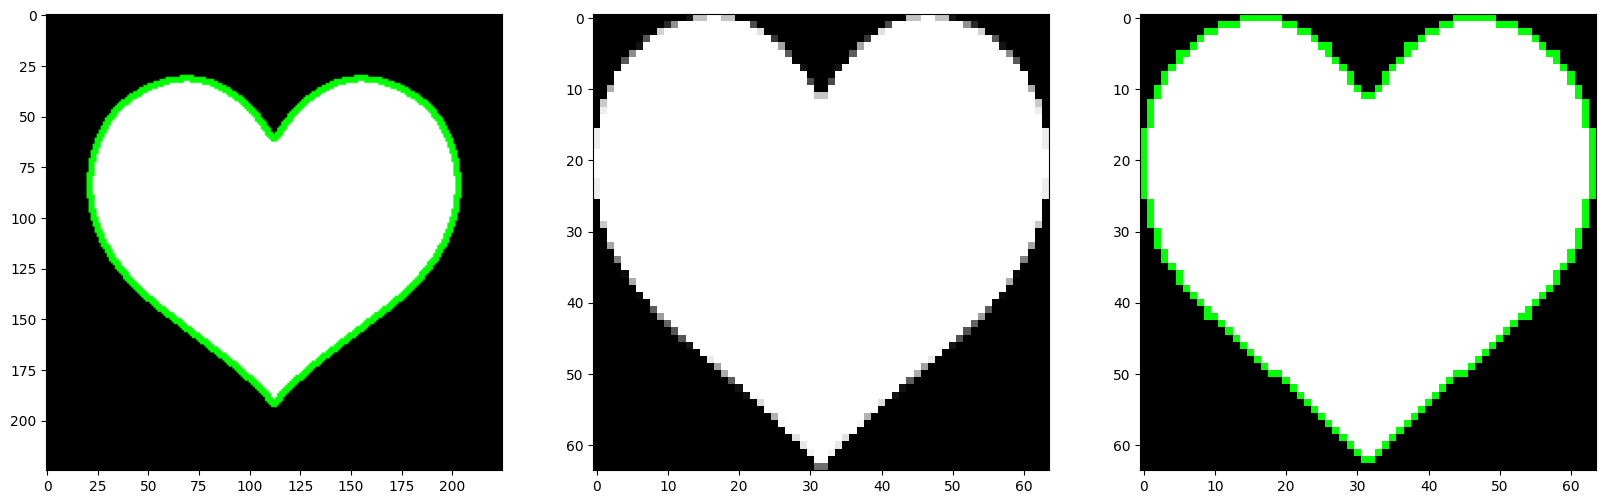

In [114]:
# Binariza a imagem
valHeart, binHeart = binarize(baseHeart)

# Acha o contorno do coração
contoursHeart, hierarchyHeart = get_contours(binHeart)

# Verifica visualmente o contorno encontrado
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
rgb_img = cv2.cvtColor(binHeart,cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img, contoursHeart, -1, (0,255,0), 2)
plt.imshow(rgb_img)

# Obtém um retângulo que circunde a região do contorno
x,y,w,h = cv2.boundingRect(contoursHeart[0])

# Pega somente a região do contorno da imagem
reducedImg = binHeart.copy()[y:y+h, x:x+w]

# Redimensiona para 64x64
resizedImg = cv2.resize(reducedImg,(64,64))

# Visualiza a região cortada
plt.subplot(1,3,2)
plt.imshow(resizedImg,cmap="gray")

# Binariza a imagem
valHeart, binReduced = binarize(resizedImg,False)

# Acha o contorno do coração
contoursReduced, hierarchyReduced = get_contours(binReduced)

# Verifica visualmente o contorno encontrado
plt.subplot(1,3,3)
rgb_img = cv2.cvtColor(binReduced,cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img, contoursReduced, -1, (0,255,0), 1)
plt.imshow(rgb_img)

# Essa lógica de encontrar a região do contorno pode ser agrupada em uma função:
def get_64x64_contour_region(img,contour):
    x,y,w,h = cv2.boundingRect(contour)
    contour_region = img.copy()[y:y+h, x:x+w]
    resizedImg = cv2.resize(contour_region,(64,64))
    return resizedImg

## Encontrnado a FFT do formato base

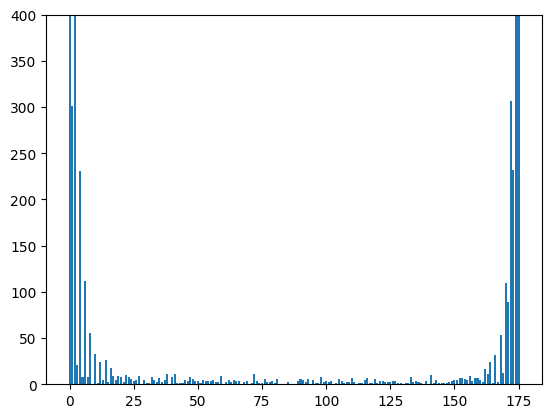

In [115]:
# Converte o contorno em um sinal complexo
complexHeart = transform_contour(contoursReduced[0])

# Calcula a fft
fftHeart = np.fft.fft(complexHeart)

# Visualiza a fft
plt.figure()
plt.bar(np.arange(len(fftHeart)),np.abs(fftHeart))
plt.ylim([0, 400])
plt.show()

# Podemos agrupar a captura da FFT com a visualização do contorno considerado em uma função
def analise_fft(img):
    contours, _ = get_contours(img)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(rgb_img, contours, -1, (0,255,0), 1)
    plt.imshow(rgb_img)
    complexContour = transform_contour(contours[0])
    dft = np.fft.fft(complexContour)
    return dft

## Avaliando as componentes relevantes da FFT no formato base

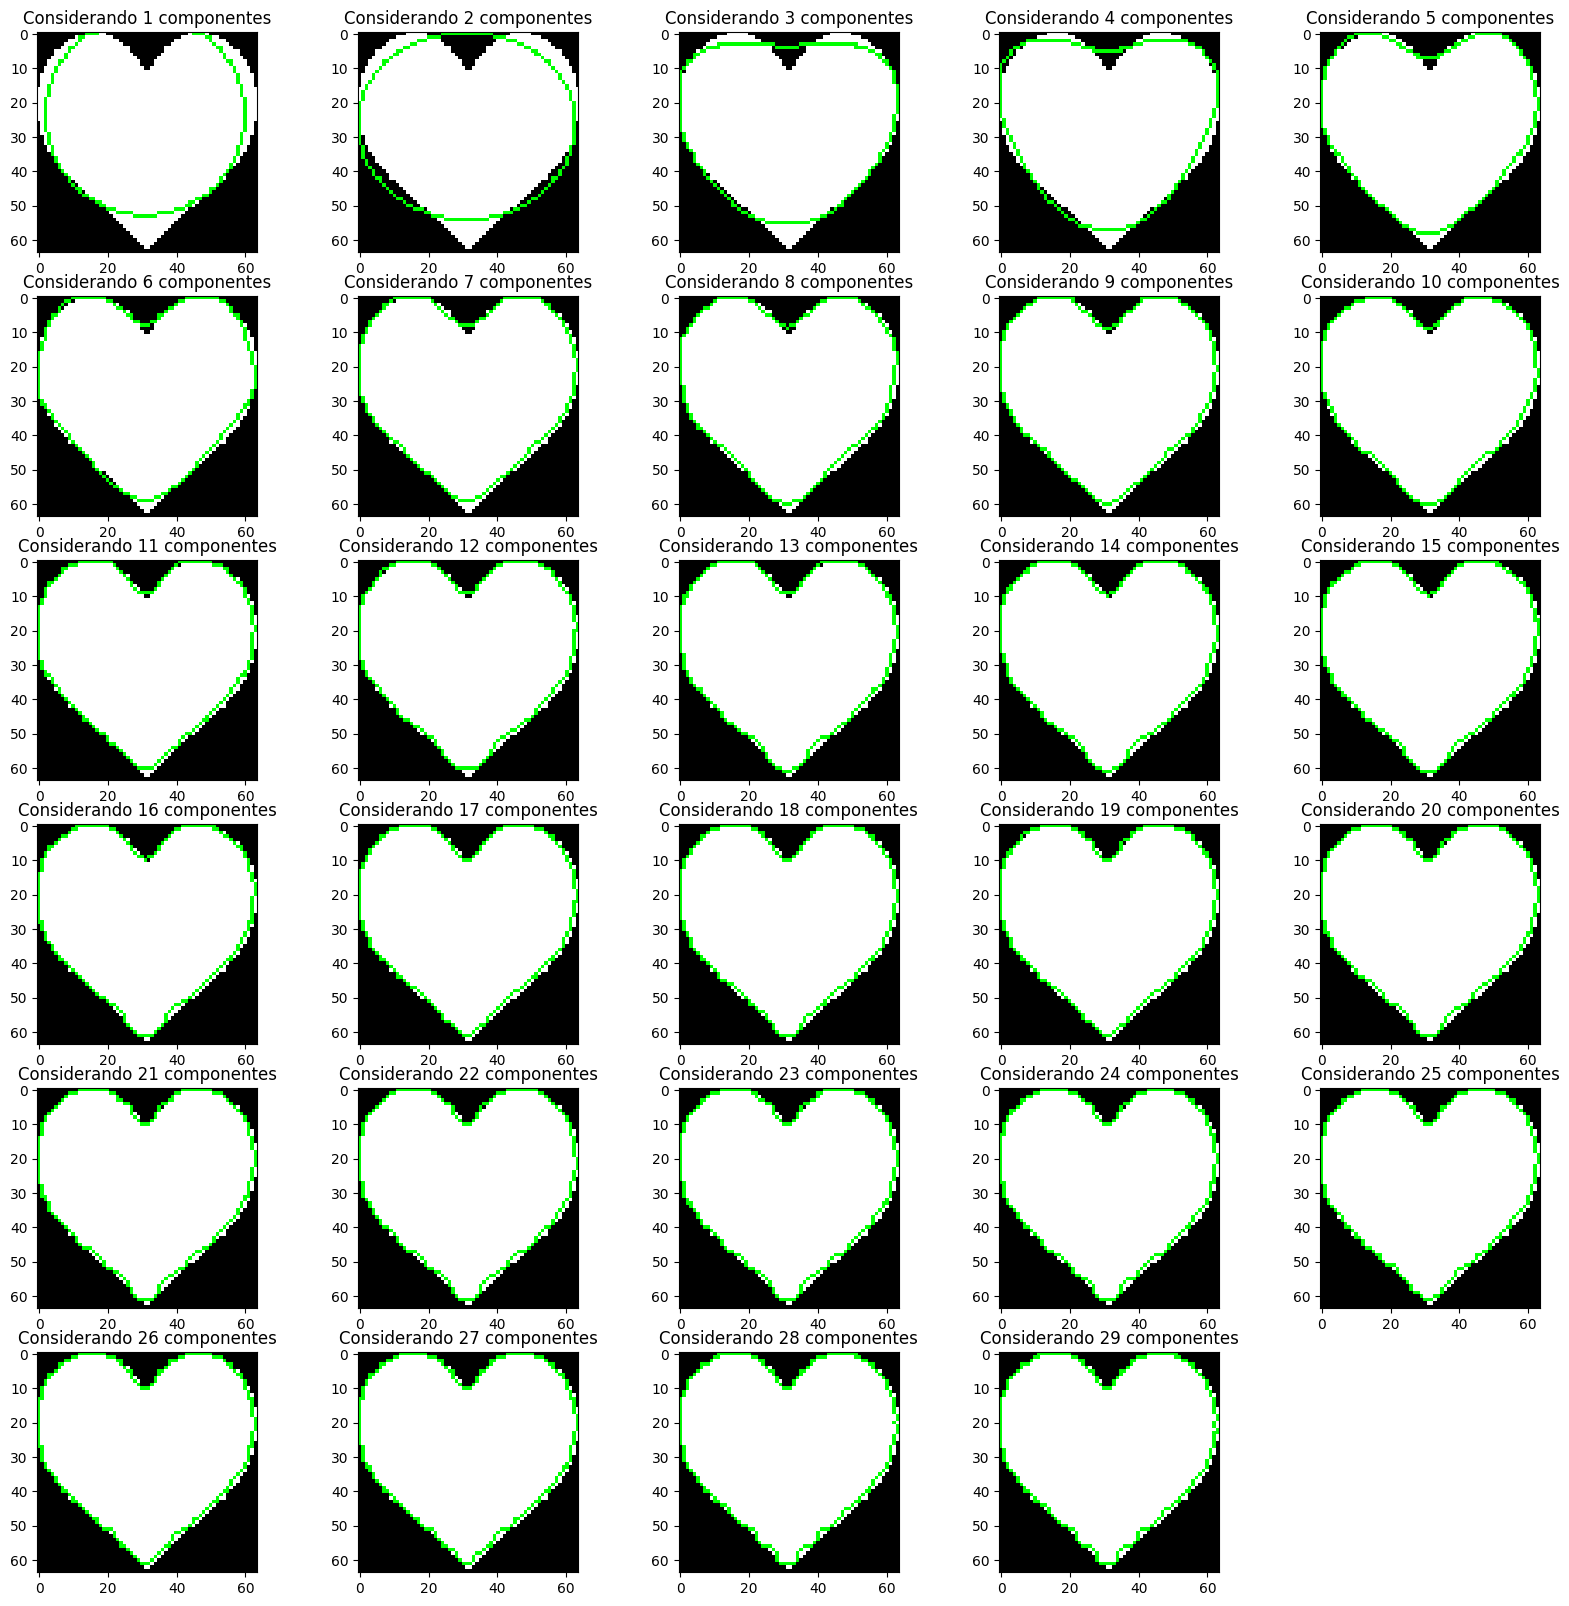

In [116]:
# Vemos como muda conforme adicionamos componentes
plt.figure(figsize=(20,20))
for N_PAR in range(1,30):
    plt.subplot(6,5,N_PAR)

    # Copiamos a dft
    dft_c = fftHeart.copy()
    # Separamos os componentes
    dft_c[N_PAR:-N_PAR] = 0
    # Achamos a inversa
    cont = np.fft.ifft(dft_c)

    cont = np.stack((cont.real, cont.imag), axis=1)
    cont = cont.reshape(-1, 1, 2).astype(int)
    # Visualizamos
    imgc = cv2.cvtColor(binReduced, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(imgc, [cont], -1, (0,255,0), 1)
    plt.imshow(imgc)
    plt.title(f"Considerando {N_PAR} componentes")


In [117]:
# 17 Fica com um formato mais flúido, então consideramos os 17 primeiros e 17 últimos componentes
firstComponents = fftHeart[0:17]
lastComponents = fftHeart[-17:]

## Importando outros contornos para comparação

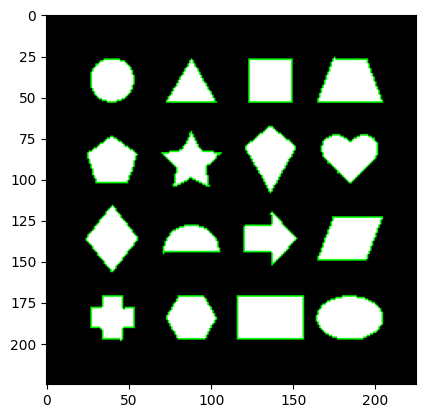

In [118]:
# Binariza a imagem
val, bin = binarize(imgs[1])

# Acha os contornos
contours, hierarchy = get_contours(bin)

# Verifica visualmente os contornos encontrados
rgb_img = cv2.cvtColor(bin,cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img, contours, -1, (0,255,0), 1)
plt.imshow(rgb_img)
plt.show()

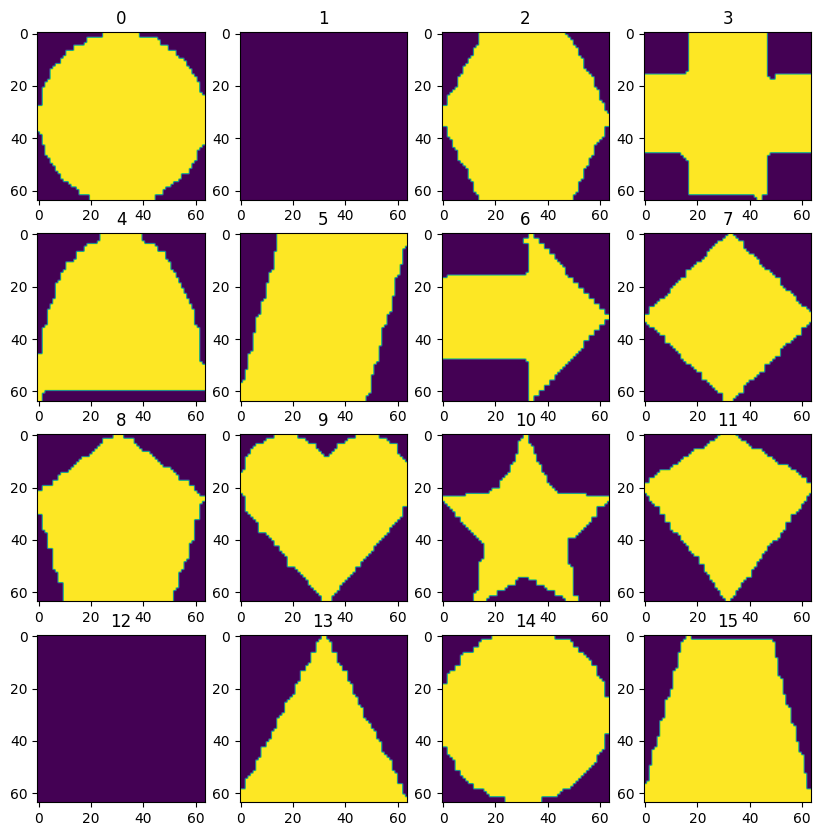

In [119]:
# Extrai os formatos da imagem, vizualizando as regiões extraídas redimensionadas
resizedShapes = []
plt.figure(figsize=(10,10))
for idx,contour in enumerate(contours):
    resizedShapes.append(binarize(get_64x64_contour_region(bin,contour),False)[1])
    plt.subplot(4,4,idx+1)
    plt.imshow(resizedShapes[-1])
    plt.title(f"{idx}")

plt.show()

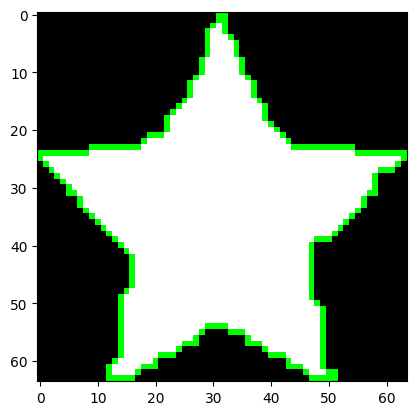

In [120]:
# Analisa a FFT da estrela
fftStar = analise_fft(resizedShapes[10])
firstComponentsStar = fftStar[0:17]
lastComponentsStar = fftStar[-17:]

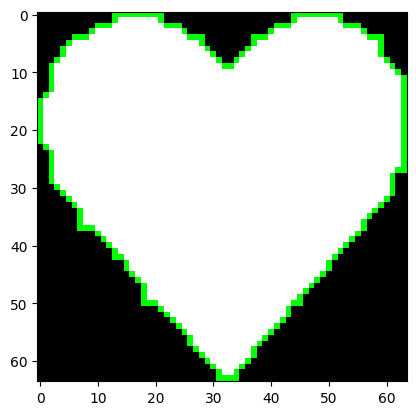

In [121]:
# Analisa a fft do outro coração
fftNewHeart = analise_fft(resizedShapes[9])
firstComponentsNewHeart = fftNewHeart[0:17]
lastComponentsNewHeart = fftNewHeart[-17:]

## Explorando as FFTs para encontrar um padrão

In [122]:
def spearmanr(x, y):
    # Passo 1: Classificar os sinais
    rank_x = np.argsort(np.argsort(x))  # Classificação de x
    rank_y = np.argsort(np.argsort(y))  # Classificação de y

    # Passo 2: Calcular as diferenças d_i entre as classificações
    d = rank_x - rank_y

    # Passo 3: Aplicar a fórmula de Spearman
    n = len(x)
    d_sum = np.sum(d**2)
    rho = 1 - (6 * d_sum) / (n * (n**2 - 1))
    return rho


# Observando as correlações
print("### CORRELAÇÕES COM OS PRIMEIROS COMPONENTES ###")
coef_spearman = spearmanr(firstComponents, firstComponentsNewHeart)
print(f"Correlação (Primeiros Componentes vs Novo Coração): {coef_spearman:.4f}")

coef_spearman = spearmanr(firstComponents, firstComponentsStar)
print(f"Correlação (Primeiros Componentes vs Estrela): {coef_spearman:.4f}")

coef_spearman = spearmanr(np.angle(firstComponents), np.angle(firstComponentsNewHeart))
print(f"Correlação (Ângulos Primeiros Componentes vs Novo Coração): {coef_spearman:.4f}")

coef_spearman = spearmanr(np.angle(firstComponents), np.angle(firstComponentsStar))
print(f"Correlação (Ângulos Primeiros Componentes vs Estrela): {coef_spearman:.4f}")

print("\n### CORRELAÇÕES COM OS ÚLTIMOS COMPONENTES ###")
coef_spearman = spearmanr(lastComponents, lastComponentsNewHeart)
print(f"Correlação (Últimos Componentes vs Novo Coração): {coef_spearman:.4f}")

coef_spearman = spearmanr(lastComponents, lastComponentsStar)
print(f"Correlação (Últimos Componentes vs Estrela): {coef_spearman:.4f}")

coef_spearman = spearmanr(np.angle(lastComponents), np.angle(lastComponentsNewHeart))
print(f"Correlação (Ângulos Últimos Componentes vs Novo Coração): {coef_spearman:.4f}")

coef_spearman = spearmanr(np.angle(lastComponents), np.angle(lastComponentsStar))
print(f"Correlação (Ângulos Últimos Componentes vs Estrela): {coef_spearman:.4f}")

### CORRELAÇÕES COM OS PRIMEIROS COMPONENTES ###
Correlação (Primeiros Componentes vs Novo Coração): 0.8824
Correlação (Primeiros Componentes vs Estrela): 0.1838
Correlação (Ângulos Primeiros Componentes vs Novo Coração): 0.7647
Correlação (Ângulos Primeiros Componentes vs Estrela): 0.1127

### CORRELAÇÕES COM OS ÚLTIMOS COMPONENTES ###
Correlação (Últimos Componentes vs Novo Coração): 0.9191
Correlação (Últimos Componentes vs Estrela): 0.3971
Correlação (Ângulos Últimos Componentes vs Novo Coração): 0.4363
Correlação (Ângulos Últimos Componentes vs Estrela): -0.0098


Observa-se que os coeficientes obtidos aparentemente distinguem bem o formato do contorno,<br>
por isso decidiu-se utilizar o Coeficiente de Spearman como métrica de comparação.<br>
Além de ser uma métrica que considera relações não lineares e independentes de escala.

In [123]:
# Combinações dos componentes (módulo e ângulo) e cálculos das correlações

# Juntando primeiros e últimos componentes
baseComponents = np.concatenate([firstComponents, lastComponents])
newHeartComponents = np.concatenate([firstComponentsNewHeart, lastComponentsNewHeart])
starComponents = np.concatenate([firstComponentsStar, lastComponentsStar])

print("### CORRELAÇÕES UTILIZANDO OS COMPONENTES COMPLETOS (MÓDULO) ###")
coef_spearman = spearmanr(baseComponents, newHeartComponents)
print(f"Correlação (Base Completa vs Novo Coração): {coef_spearman:.4f}")

coef_spearman = spearmanr(baseComponents, starComponents)
print(f"Correlação (Base Completa vs Estrela): {coef_spearman:.4f}")

# Trabalhando com os ângulos dos componentes
baseComponents = np.angle(np.concatenate([firstComponents, lastComponents]))
newHeartComponents = np.angle(np.concatenate([firstComponentsNewHeart, lastComponentsNewHeart]))
starComponents = np.angle(np.concatenate([firstComponentsStar, lastComponentsStar]))

print("\n### CORRELAÇÕES UTILIZANDO OS COMPONENTES COMPLETOS (ÂNGULOS) ###")
coef_spearman = spearmanr(baseComponents, newHeartComponents)
print(f"Correlação (Ângulo Base Completa vs Novo Coração): {coef_spearman:.4f}")

coef_spearman = spearmanr(baseComponents, starComponents)
print(f"Correlação (Ângulo Base Completa vs Estrela): {coef_spearman:.4f}")

### CORRELAÇÕES UTILIZANDO OS COMPONENTES COMPLETOS (MÓDULO) ###
Correlação (Base Completa vs Novo Coração): 0.9169
Correlação (Base Completa vs Estrela): 0.2480

### CORRELAÇÕES UTILIZANDO OS COMPONENTES COMPLETOS (ÂNGULOS) ###
Correlação (Ângulo Base Completa vs Novo Coração): 0.5618
Correlação (Ângulo Base Completa vs Estrela): 0.0252


Observa-se que o resultado ainda demonstra a distinção entre os contornos claramente,<br>
Assim, para ter uma métrica única vamos considerar os componentes combinados.

In [124]:
# Combinação dos primeiros e últimos componentes para análise completa
heart_base_components = np.concatenate([firstComponents, lastComponents])  # Combina os valores completos
heart_angle_base_components = np.angle(heart_base_components)  # Calcula os ângulos dos valores combinados

# Extraindo padrões de classificação (ranks) com base nos valores
heart_spearman_pattern = np.argsort(np.argsort(heart_base_components))  # Classificação pelo módulo (magnitude)
heart_angle_spearman_pattern = np.argsort(np.argsort(heart_angle_base_components))  # Classificação pelos ângulos

# Impressão dos padrões extraídos
print("Padrão de classificação pelo módulo (Spearman):")
print(heart_spearman_pattern)

print("\nPadrão de classificação pelos ângulos (Spearman):")
print(heart_angle_spearman_pattern)

Padrão de classificação pelo módulo (Spearman):
[33  2  1 25  4 19 29 21 28 17  8 18  7 15 22 20 24 11 10 14  9 12 27 13
 26 16  5 23  3  6 30 31 32  0]

Padrão de classificação pelos ângulos (Spearman):
[23 29 32 22  6 11 14 20 24  9 28 17  1  5 10 13 19 31 33  3  8 27 16  0
 25 26 30 18  2  7 12 15 21  4]


## Mesclando as ideias

In [22]:
def heartFinder(img, INVERSE_THRESHOLD = True,MIN_CONTOUR_SPEARMAN = 0.7, MIN_CONTOUR_ANGLE_SPEARMAN=0.4):
    """
    Identifica contornos na imagem binária que se assemelham a um coração com base em padrões de Spearman.

    Args:
        img (numpy.ndarray): Imagem de um único canal contendo os contornos a serem analisados.
        INVERSE_THRESHOLD (boolean, optional): Flag para alterar o formato de binarização por threshold da imagem. 
        MIN_CONTOUR_SPEARMAN (float, optional): Valor mínimo do coeficiente de Spearman para o contorno. Default é 0.7.
        MIN_CONTOUR_ANGLE_SPEARMAN (float, optional): Valor mínimo do coeficiente de Spearman para o ângulo do contorno. Default é 0.4.

    Returns:
        list: Lista de contornos identificados como corações.
    """
    
    # Define o padrão esperado
    HEART_SPEARMAN_RANK_PATTERN = [33,2,1,25,4,19,29,21,28,17,8,18,7,15,22,20,24,11,10,14,9,12,27,13,26,16,5,23,3,6,30,31,32,0]
    HEART_SPEARMAN_ANGLE_RANK_PATTERN = [23,29,32,22,6,11,14,20,24,9,28,17,1,5,10,13,19,31,33,3,8,27,16,0,25,26,30,18,2,7,12,15,21,4]
    
    # Define as funções auxiliares
    def get_64x64_contour_region(img,contour):
        """
        Recorta uma região ao redor de um contorno e redimensiona para 64x64 pixels.

        Args:
            img (numpy.ndarray): Imagem original.
            contour (numpy.ndarray): Contorno a ser analisado.

        Returns:
            numpy.ndarray: Região do contorno redimensionada para 64x64 pixels.
        """
        
        # Obtêm um retângulo que contém o contorno
        x,y,w,h = cv2.boundingRect(contour)
        # Extrai a região retangular encontrada na imagem
        contour_region = img.copy()[y:y+h, x:x+w]
        # Redimensiona o elemento contornado no formato 64x64 para padronização
        resized_region = cv2.resize(contour_region,(64,64))
        # Retorna o elemento contornado em 64x64
        return resized_region
    
    def spearman(heart_rank_pattern,dft_17):
        """
        Calcula o coeficiente de Spearman entre um padrão de referência e os dados fornecidos.

        Args:
            heart_rank_pattern (numpy.ndarray): Padrão de classificação de referência.
            dft_17 (numpy.ndarray): Dados a serem analisados, obtidos da FFT.

        Returns:
            float: Coeficiente de Spearman calculado.
        """
        
        # Passo 1: Classificar os sinais
        dft_rank = np.argsort(np.argsort(dft_17))

        # Passo 2: Calcular as diferenças d_i entre as classificações
        d = heart_rank_pattern - dft_rank

        # Passo 3: Aplicar a fórmula de Spearman
        n = len(heart_rank_pattern)
        d_sum = np.sum(d**2)
        rho = 1 - (6 * d_sum) / (n * (n**2 - 1))
        return rho
    
    # Binariza a imagem
    if INVERSE_THRESHOLD:
        bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    else: 
        bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Encontrar os contornos
    macro_contours = cv2.findContours(bin_img,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    # Encontrar a região dos contornos na imagem
    # Recortar e redimensionar cada uma das regiões dos contornos
    resized_contours_area = []
    for contour in macro_contours:
            resized_contours_area.append(get_64x64_contour_region(bin_img,contour))

    heart_indexes = []
    # Para cada região recortada:
    for contour_idx,area in enumerate(resized_contours_area):
        # Pegar novamente o contorno agora redimensionado
        resized_curr_contour = cv2.findContours(area,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0]
        # Transformar o contorno em complexo
        complex_contour = resized_curr_contour[:,0,0] + resized_curr_contour[:,0,1]*1j
        # Calcular a FFT
        dft = np.fft.fft(complex_contour)
        # Separar os 17 últimos e 17 primeiros componentes 
        dft_17 = np.concatenate([dft[:17],dft[-17:]])
        # Determina o ângulo dos componentes
        dft_17_angle = np.angle(dft_17)
        # Calcular os coeficientes de Spearman
        contour_spearman = spearman(HEART_SPEARMAN_RANK_PATTERN,dft_17)
        contour_angle_spearman = spearman(HEART_SPEARMAN_ANGLE_RANK_PATTERN,dft_17_angle)  
        # print(contour_spearman, contour_angle_spearman)      
        # Verificar se está dentro do intervalo esperado para caracterizar como coração ou não
        if contour_spearman > MIN_CONTOUR_SPEARMAN and contour_angle_spearman > MIN_CONTOUR_ANGLE_SPEARMAN:
            # Salvamos o coração
            heart_indexes.append(contour_idx)
    # Separa o contorno dos corações para retornar ao usuário
    heart_contours = [macro_contours[idx] for idx in heart_indexes]
    
    return heart_contours

### Testando o algoritmo

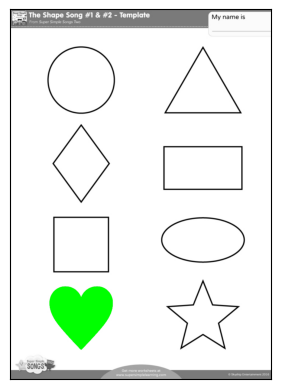

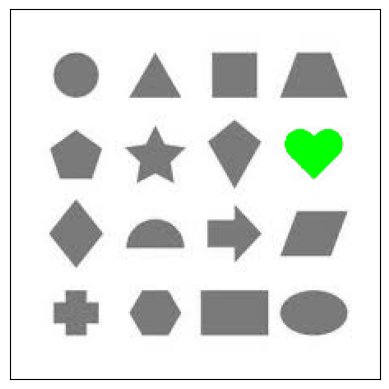

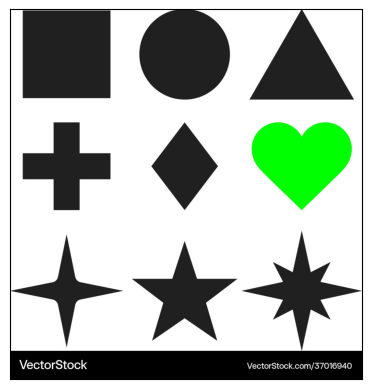

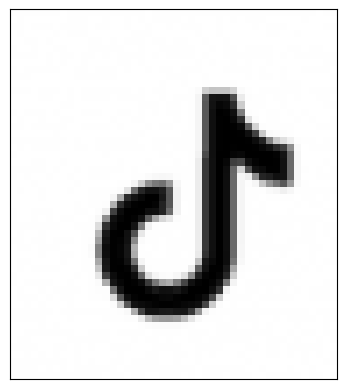

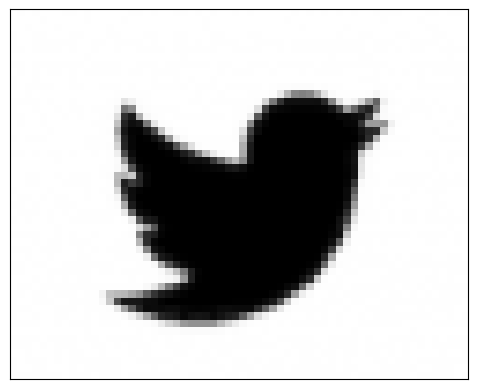

In [23]:
# Para cada imagem dentro das fornecidas
for img in imgs:
    # Aplica o algoritmo para encontrar os corações nas imagens
    heart_contours = heartFinder(img)
    # Exibe os contornos encontrados
    rgb_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(rgb_img, heart_contours, -1, (0,255,0), -1)
    plt.imshow(rgb_img);plt.xticks([]);plt.yticks([])
    plt.show()